In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/kaggle_histo/train/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_mobilenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 474225 images belonging to 2 classes.
Found 158075 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 474225
nb_validation_samples: 158075

predict_size_train: 14820
predict_size_validation: 4940
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = MobileNet(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 474225 samples, validate on 158075 samples
Epoch 1/1000
 - 53s - loss: 0.3338 - acc: 0.8568 - val_loss: 0.2962 - val_acc: 0.8761
Epoch 2/1000
 - 51s - loss: 0.3000 - acc: 0.8766 - val_loss: 0.2882 - val_acc: 0.8822
Epoch 3/1000
 - 51s - loss: 0.2912 - acc: 0.8832 - val_loss: 0.2886 - val_acc: 0.8841
Epoch 4/1000
 - 51s - loss: 0.2864 - acc: 0.8863 - val_loss: 0.2820 - val_acc: 0.8883
Epoch 5/1000
 - 51s - loss: 0.2826 - acc: 0.8892 - val_loss: 0.2792 - val_acc: 0.8905
Epoch 6/1000
 - 51s - loss: 0.2804 - acc: 0.8909 - val_loss: 0.2814 - val_acc: 0.8896
Epoch 7/1000
 - 51s - loss: 0.2784 - acc: 0.8923 - val_loss: 0.2822 - val_acc: 0.8906
Epoch 8/1000
 - 51s - loss: 0.2772 - acc: 0.8938 - val_loss: 0.2783 - val_acc: 0.8921
Epoch 9/1000
 - 51s - loss: 0.2763 - acc: 0.8945 - val_loss: 0.2805 - val_acc: 0.8920
Epoch 10/1000
 - 51s - loss: 0.2753 - acc: 0.8951 - val_loss: 0.2837 - val_acc: 0.8921
Epoch 11/1000
 - 51s - loss: 0.2744 - acc: 0.8963 - val_loss: 0.2777 - val_acc: 0.8933


Epoch 95/1000
 - 51s - loss: 0.2729 - acc: 0.9061 - val_loss: 0.3055 - val_acc: 0.8967
Epoch 96/1000
 - 51s - loss: 0.2718 - acc: 0.9071 - val_loss: 0.3003 - val_acc: 0.8971
Epoch 97/1000
 - 51s - loss: 0.2724 - acc: 0.9068 - val_loss: 0.2987 - val_acc: 0.8966
Epoch 98/1000
 - 51s - loss: 0.2722 - acc: 0.9063 - val_loss: 0.2992 - val_acc: 0.8973
Epoch 99/1000
 - 51s - loss: 0.2720 - acc: 0.9065 - val_loss: 0.2989 - val_acc: 0.8966
Epoch 100/1000
 - 51s - loss: 0.2721 - acc: 0.9067 - val_loss: 0.3021 - val_acc: 0.8970
Epoch 101/1000
 - 51s - loss: 0.2717 - acc: 0.9071 - val_loss: 0.3005 - val_acc: 0.8960
Epoch 102/1000
 - 51s - loss: 0.2731 - acc: 0.9065 - val_loss: 0.3067 - val_acc: 0.8954
Epoch 103/1000
 - 51s - loss: 0.2725 - acc: 0.9067 - val_loss: 0.3026 - val_acc: 0.8966
Epoch 104/1000
 - 51s - loss: 0.2729 - acc: 0.9067 - val_loss: 0.3082 - val_acc: 0.8968
Epoch 105/1000
 - 51s - loss: 0.2720 - acc: 0.9068 - val_loss: 0.3041 - val_acc: 0.8958
Epoch 106/1000
 - 51s - loss: 0.2723 

 - 51s - loss: 0.2765 - acc: 0.9076 - val_loss: 0.3125 - val_acc: 0.8957
Epoch 189/1000
 - 51s - loss: 0.2777 - acc: 0.9072 - val_loss: 0.3117 - val_acc: 0.8950
Epoch 190/1000
 - 51s - loss: 0.2770 - acc: 0.9076 - val_loss: 0.3127 - val_acc: 0.8960
Epoch 191/1000
 - 51s - loss: 0.2779 - acc: 0.9074 - val_loss: 0.3155 - val_acc: 0.8965
Epoch 192/1000
 - 51s - loss: 0.2765 - acc: 0.9074 - val_loss: 0.3162 - val_acc: 0.8959
Epoch 193/1000
 - 51s - loss: 0.2764 - acc: 0.9075 - val_loss: 0.3111 - val_acc: 0.8949
Epoch 194/1000
 - 51s - loss: 0.2771 - acc: 0.9075 - val_loss: 0.3129 - val_acc: 0.8954
Epoch 195/1000
 - 51s - loss: 0.2769 - acc: 0.9078 - val_loss: 0.3138 - val_acc: 0.8963
Epoch 196/1000
 - 51s - loss: 0.2764 - acc: 0.9076 - val_loss: 0.3118 - val_acc: 0.8955
Epoch 197/1000
 - 51s - loss: 0.2778 - acc: 0.9072 - val_loss: 0.3170 - val_acc: 0.8957
Epoch 198/1000
 - 51s - loss: 0.2764 - acc: 0.9083 - val_loss: 0.3146 - val_acc: 0.8952
Epoch 199/1000
 - 51s - loss: 0.2775 - acc: 0.9

Epoch 282/1000
 - 51s - loss: 0.2817 - acc: 0.9081 - val_loss: 0.3240 - val_acc: 0.8958
Epoch 283/1000
 - 51s - loss: 0.2813 - acc: 0.9080 - val_loss: 0.3211 - val_acc: 0.8948
Epoch 284/1000
 - 51s - loss: 0.2812 - acc: 0.9074 - val_loss: 0.3199 - val_acc: 0.8953
Epoch 285/1000
 - 51s - loss: 0.2817 - acc: 0.9076 - val_loss: 0.3194 - val_acc: 0.8958
Epoch 286/1000
 - 51s - loss: 0.2813 - acc: 0.9074 - val_loss: 0.3190 - val_acc: 0.8943
Epoch 287/1000
 - 51s - loss: 0.2820 - acc: 0.9074 - val_loss: 0.3207 - val_acc: 0.8951
Epoch 288/1000
 - 51s - loss: 0.2814 - acc: 0.9072 - val_loss: 0.3219 - val_acc: 0.8957
Epoch 289/1000
 - 51s - loss: 0.2809 - acc: 0.9080 - val_loss: 0.3180 - val_acc: 0.8953
Epoch 290/1000
 - 51s - loss: 0.2822 - acc: 0.9074 - val_loss: 0.3163 - val_acc: 0.8949
Epoch 291/1000
 - 51s - loss: 0.2817 - acc: 0.9077 - val_loss: 0.3192 - val_acc: 0.8937
Epoch 292/1000
 - 51s - loss: 0.2810 - acc: 0.9072 - val_loss: 0.3262 - val_acc: 0.8942
Epoch 293/1000
 - 51s - loss: 0.

 - 51s - loss: 0.2860 - acc: 0.9077 - val_loss: 0.3273 - val_acc: 0.8949
Epoch 376/1000
 - 51s - loss: 0.2851 - acc: 0.9074 - val_loss: 0.3328 - val_acc: 0.8947
Epoch 377/1000
 - 51s - loss: 0.2860 - acc: 0.9081 - val_loss: 0.3290 - val_acc: 0.8941
Epoch 378/1000
 - 51s - loss: 0.2861 - acc: 0.9072 - val_loss: 0.3215 - val_acc: 0.8945
Epoch 379/1000
 - 51s - loss: 0.2864 - acc: 0.9075 - val_loss: 0.3342 - val_acc: 0.8954
Epoch 380/1000
 - 51s - loss: 0.2862 - acc: 0.9073 - val_loss: 0.3247 - val_acc: 0.8945
Epoch 381/1000
 - 51s - loss: 0.2854 - acc: 0.9078 - val_loss: 0.3271 - val_acc: 0.8953
Epoch 382/1000
 - 51s - loss: 0.2857 - acc: 0.9073 - val_loss: 0.3321 - val_acc: 0.8943
Epoch 383/1000
 - 51s - loss: 0.2858 - acc: 0.9079 - val_loss: 0.3281 - val_acc: 0.8946
Epoch 384/1000
 - 51s - loss: 0.2853 - acc: 0.9071 - val_loss: 0.3275 - val_acc: 0.8949
Epoch 385/1000
 - 51s - loss: 0.2878 - acc: 0.9073 - val_loss: 0.3282 - val_acc: 0.8942
Epoch 386/1000
 - 51s - loss: 0.2860 - acc: 0.9

Epoch 469/1000
 - 51s - loss: 0.2902 - acc: 0.9069 - val_loss: 0.3311 - val_acc: 0.8945
Epoch 470/1000
 - 51s - loss: 0.2891 - acc: 0.9073 - val_loss: 0.3356 - val_acc: 0.8940
Epoch 471/1000
 - 51s - loss: 0.2905 - acc: 0.9074 - val_loss: 0.3377 - val_acc: 0.8939
Epoch 472/1000
 - 51s - loss: 0.2899 - acc: 0.9068 - val_loss: 0.3402 - val_acc: 0.8947
Epoch 473/1000
 - 51s - loss: 0.2903 - acc: 0.9072 - val_loss: 0.3387 - val_acc: 0.8946
Epoch 474/1000
 - 51s - loss: 0.2901 - acc: 0.9075 - val_loss: 0.3352 - val_acc: 0.8946
Epoch 475/1000
 - 51s - loss: 0.2908 - acc: 0.9069 - val_loss: 0.3326 - val_acc: 0.8942
Epoch 476/1000
 - 51s - loss: 0.2907 - acc: 0.9062 - val_loss: 0.3334 - val_acc: 0.8942
Epoch 477/1000
 - 51s - loss: 0.2908 - acc: 0.9073 - val_loss: 0.3339 - val_acc: 0.8941
Epoch 478/1000
 - 51s - loss: 0.2897 - acc: 0.9073 - val_loss: 0.3335 - val_acc: 0.8944
Epoch 479/1000
 - 51s - loss: 0.2895 - acc: 0.9074 - val_loss: 0.3333 - val_acc: 0.8941
Epoch 480/1000
 - 51s - loss: 0.

 - 51s - loss: 0.2938 - acc: 0.9071 - val_loss: 0.3358 - val_acc: 0.8934
Epoch 563/1000
 - 51s - loss: 0.2937 - acc: 0.9064 - val_loss: 0.3460 - val_acc: 0.8929
Epoch 564/1000
 - 51s - loss: 0.2931 - acc: 0.9069 - val_loss: 0.3412 - val_acc: 0.8943
Epoch 565/1000
 - 51s - loss: 0.2940 - acc: 0.9069 - val_loss: 0.3397 - val_acc: 0.8935
Epoch 566/1000
 - 51s - loss: 0.2942 - acc: 0.9068 - val_loss: 0.3381 - val_acc: 0.8938
Epoch 567/1000
 - 51s - loss: 0.2940 - acc: 0.9070 - val_loss: 0.3390 - val_acc: 0.8930
Epoch 568/1000
 - 51s - loss: 0.2932 - acc: 0.9068 - val_loss: 0.3417 - val_acc: 0.8933
Epoch 569/1000
 - 51s - loss: 0.2940 - acc: 0.9065 - val_loss: 0.3372 - val_acc: 0.8940
Epoch 570/1000
 - 51s - loss: 0.2941 - acc: 0.9067 - val_loss: 0.3397 - val_acc: 0.8947
Epoch 571/1000
 - 51s - loss: 0.2938 - acc: 0.9068 - val_loss: 0.3424 - val_acc: 0.8941
Epoch 572/1000
 - 51s - loss: 0.2928 - acc: 0.9068 - val_loss: 0.3346 - val_acc: 0.8942
Epoch 573/1000
 - 51s - loss: 0.2958 - acc: 0.9

Epoch 656/1000
 - 51s - loss: 0.2968 - acc: 0.9067 - val_loss: 0.3446 - val_acc: 0.8937
Epoch 657/1000
 - 51s - loss: 0.2961 - acc: 0.9065 - val_loss: 0.3478 - val_acc: 0.8942
Epoch 658/1000
 - 51s - loss: 0.2965 - acc: 0.9068 - val_loss: 0.3444 - val_acc: 0.8934
Epoch 659/1000
 - 51s - loss: 0.2981 - acc: 0.9065 - val_loss: 0.3449 - val_acc: 0.8949
Epoch 660/1000
 - 51s - loss: 0.2973 - acc: 0.9065 - val_loss: 0.3424 - val_acc: 0.8935
Epoch 661/1000
 - 51s - loss: 0.2970 - acc: 0.9065 - val_loss: 0.3448 - val_acc: 0.8940
Epoch 662/1000
 - 51s - loss: 0.2986 - acc: 0.9058 - val_loss: 0.3429 - val_acc: 0.8941
Epoch 663/1000
 - 51s - loss: 0.2983 - acc: 0.9070 - val_loss: 0.3479 - val_acc: 0.8935
Epoch 664/1000
 - 51s - loss: 0.2981 - acc: 0.9065 - val_loss: 0.3453 - val_acc: 0.8933
Epoch 665/1000
 - 51s - loss: 0.2964 - acc: 0.9066 - val_loss: 0.3506 - val_acc: 0.8936
Epoch 666/1000
 - 51s - loss: 0.2976 - acc: 0.9066 - val_loss: 0.3377 - val_acc: 0.8932
Epoch 667/1000
 - 51s - loss: 0.

 - 52s - loss: 0.3000 - acc: 0.9068 - val_loss: 0.3463 - val_acc: 0.8920
Epoch 750/1000
 - 52s - loss: 0.3003 - acc: 0.9066 - val_loss: 0.3498 - val_acc: 0.8927
Epoch 751/1000
 - 52s - loss: 0.3002 - acc: 0.9065 - val_loss: 0.3549 - val_acc: 0.8939
Epoch 752/1000
 - 52s - loss: 0.3013 - acc: 0.9063 - val_loss: 0.3458 - val_acc: 0.8933
Epoch 753/1000
 - 52s - loss: 0.3005 - acc: 0.9065 - val_loss: 0.3487 - val_acc: 0.8928
Epoch 754/1000
 - 52s - loss: 0.3009 - acc: 0.9065 - val_loss: 0.3441 - val_acc: 0.8935
Epoch 755/1000
 - 52s - loss: 0.3009 - acc: 0.9060 - val_loss: 0.3452 - val_acc: 0.8930
Epoch 756/1000
 - 52s - loss: 0.3008 - acc: 0.9064 - val_loss: 0.3495 - val_acc: 0.8928
Epoch 757/1000
 - 52s - loss: 0.3006 - acc: 0.9063 - val_loss: 0.3492 - val_acc: 0.8921
Epoch 758/1000
 - 52s - loss: 0.3006 - acc: 0.9063 - val_loss: 0.3500 - val_acc: 0.8931
Epoch 759/1000
 - 52s - loss: 0.3000 - acc: 0.9064 - val_loss: 0.3470 - val_acc: 0.8938
Epoch 760/1000
 - 52s - loss: 0.3011 - acc: 0.9

Epoch 843/1000
 - 51s - loss: 0.3044 - acc: 0.9061 - val_loss: 0.3609 - val_acc: 0.8936
Epoch 844/1000
 - 51s - loss: 0.3036 - acc: 0.9064 - val_loss: 0.3525 - val_acc: 0.8924
Epoch 845/1000
 - 51s - loss: 0.3037 - acc: 0.9065 - val_loss: 0.3507 - val_acc: 0.8934
Epoch 846/1000
 - 52s - loss: 0.3044 - acc: 0.9062 - val_loss: 0.3526 - val_acc: 0.8933
Epoch 847/1000
 - 52s - loss: 0.3029 - acc: 0.9062 - val_loss: 0.3605 - val_acc: 0.8938
Epoch 848/1000
 - 51s - loss: 0.3041 - acc: 0.9058 - val_loss: 0.3563 - val_acc: 0.8930
Epoch 849/1000
 - 51s - loss: 0.3037 - acc: 0.9060 - val_loss: 0.3617 - val_acc: 0.8928
Epoch 850/1000
 - 51s - loss: 0.3044 - acc: 0.9058 - val_loss: 0.3568 - val_acc: 0.8931
Epoch 851/1000
 - 51s - loss: 0.3047 - acc: 0.9061 - val_loss: 0.3590 - val_acc: 0.8929
Epoch 852/1000
 - 52s - loss: 0.3035 - acc: 0.9064 - val_loss: 0.3558 - val_acc: 0.8930
Epoch 853/1000
 - 52s - loss: 0.3049 - acc: 0.9064 - val_loss: 0.3567 - val_acc: 0.8924
Epoch 854/1000
 - 51s - loss: 0.

 - 51s - loss: 0.3076 - acc: 0.9059 - val_loss: 0.3637 - val_acc: 0.8921
Epoch 937/1000
 - 52s - loss: 0.3077 - acc: 0.9057 - val_loss: 0.3656 - val_acc: 0.8929
Epoch 938/1000
 - 51s - loss: 0.3068 - acc: 0.9060 - val_loss: 0.3579 - val_acc: 0.8920
Epoch 939/1000
 - 52s - loss: 0.3080 - acc: 0.9060 - val_loss: 0.3574 - val_acc: 0.8920
Epoch 940/1000
 - 51s - loss: 0.3078 - acc: 0.9061 - val_loss: 0.3553 - val_acc: 0.8916
Epoch 941/1000
 - 51s - loss: 0.3069 - acc: 0.9058 - val_loss: 0.3638 - val_acc: 0.8927
Epoch 942/1000
 - 51s - loss: 0.3061 - acc: 0.9058 - val_loss: 0.3563 - val_acc: 0.8927
Epoch 943/1000
 - 52s - loss: 0.3061 - acc: 0.9058 - val_loss: 0.3633 - val_acc: 0.8929
Epoch 944/1000
 - 51s - loss: 0.3067 - acc: 0.9058 - val_loss: 0.3620 - val_acc: 0.8931
Epoch 945/1000
 - 51s - loss: 0.3086 - acc: 0.9062 - val_loss: 0.3604 - val_acc: 0.8930
Epoch 946/1000
 - 51s - loss: 0.3078 - acc: 0.9062 - val_loss: 0.3536 - val_acc: 0.8921
Epoch 947/1000
 - 51s - loss: 0.3079 - acc: 0.9

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.890942581300813


Confusion Matrix
[[5192 1176]
 [ 541 8835]]


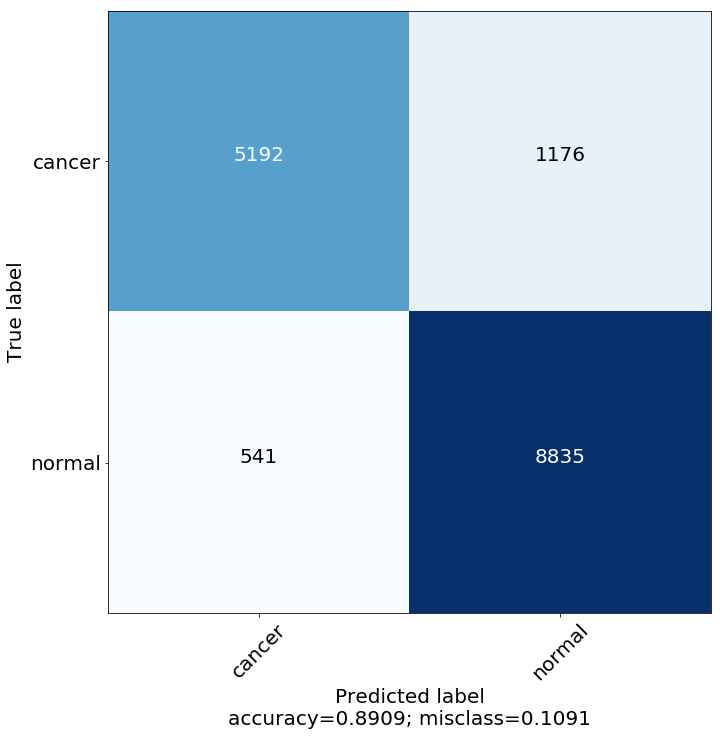

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5192 1176]
 [ 541 8835]]
              precision    recall  f1-score   support

      cancer       0.91      0.82      0.86      6368
      normal       0.88      0.94      0.91      9376

   micro avg       0.89      0.89      0.89     15744
   macro avg       0.89      0.88      0.88     15744
weighted avg       0.89      0.89      0.89     15744



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  90.56340484911914
Specificity :  88.25292178603536


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8940816331757725


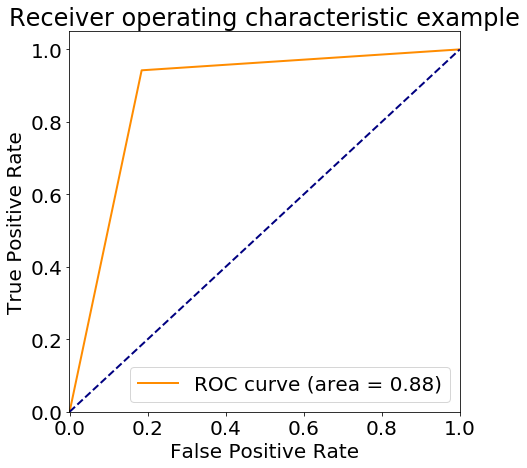

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 0s 30us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

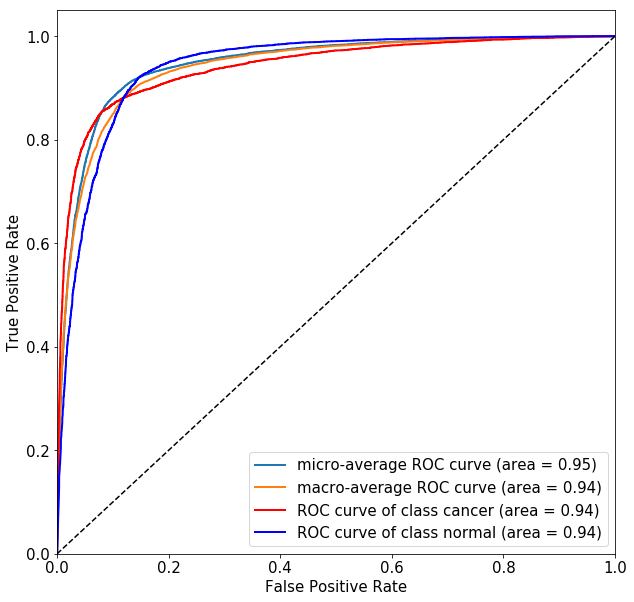

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.890942581300813
Precision: 0.8825292178603537
Recall: 0.9422994880546075
tp: 8835
fp: 1176
tn: 5192
fn: 541


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.9114354980141331


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9114354980141333


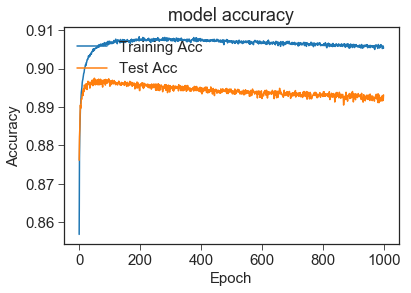

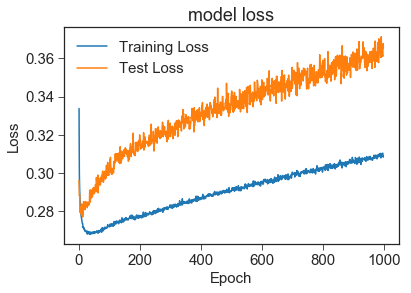

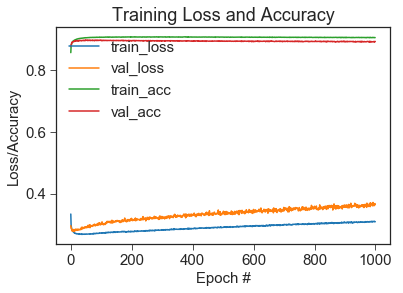

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")